# Feature Selection

This notebook includes:
* Feature Variance
* ANOVA
* Mutual Info
* Feature Importances
* Permutation Importances

## Imports and Global Settings

In [1]:
import time
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
sns.set_theme(style="whitegrid")

## Helper Functions

In [2]:
def show_values_on_bars(axs, h_v="h", space=0.5):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 1.6
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## Loading Data

In [3]:
start = time.perf_counter()

In [4]:
# EC2
filepath_prefix = "/home/ubuntu/"
# Local

# filepath_prefix = "/home/jeff/Documents/Data_Science_Projects/Yelp_Reviews/data/full_data/model_ready/"

In [5]:
train_records_to_load = 10000
test_records_to_load = 1000

In [6]:
datatypes = {'target_reg': 'int16',
 'review_stars': 'int16',
 'NB_prob': 'float32',
 'svm_pred': 'float32',
 'ft_prob': 'float32',
 'lda_t1': 'float32',
 'lda_t2': 'float32',
 'lda_t3': 'float32',
 'lda_t4': 'float32',
 'lda_t5': 'float32',
 'grade_level': 'float32',
 'polarity': 'float32',
 'subjectivity': 'float32',
 'word_cnt': 'int16',
 'character_cnt': 'int16',
 'num_cnt': 'int16',
 'uppercase_cnt': 'int16',
 '#@_cnt': 'int16',
 'sentence_cnt': 'int16',
 'lexicon_cnt': 'int16',
 'syllable_cnt': 'int16',
 'avg_word_len': 'float32',
 'token_cnt': 'int16',
 'stopword_cnt': 'int16',
 'stopword_pct': 'float32',
 'ent_cnt': 'int16',
 'ent_pct': 'float32',
 'pos_adj_pct': 'float32',
 'pos_adj_cnt': 'int16',
 'pos_adp_pct': 'float32',
 'pos_adp_cnt': 'int16',
 'pos_adv_pct': 'float32',
 'pos_adv_cnt': 'int16',
 'pos_aux_pct': 'float32',
 'pos_aux_cnt': 'int16',
 'pos_conj_pct': 'float32',
 'pos_conj_cnt': 'int16',
 'pos_det_pct': 'float32',
 'pos_det_cnt': 'int16',
 'pos_intj_pct': 'float32',
 'pos_intj_cnt': 'int16',
 'pos_noun_pct': 'float32',
 'pos_noun_cnt': 'int16',
 'pos_num_pct': 'float32',
 'pos_num_cnt': 'int16',
 'pos_part_pct': 'float32',
 'pos_part_cnt': 'int16',
 'pos_pron_pct': 'float32',
 'pos_pron_cnt': 'int16',
 'pos_propn_pct': 'float32',
 'pos_propn_cnt': 'int16',
 'pos_punct_pct': 'float32',
 'pos_punct_cnt': 'int16',
 'pos_sconj_pct': 'float32',
 'pos_sconj_cnt': 'int16',
 'pos_sym_pct': 'float32',
 'pos_sym_cnt': 'int16',
 'pos_verb_pct': 'float32',
 'pos_verb_cnt': 'int16',
 'pos_x_pct': 'float32',
 'pos_x_cnt': 'int16',
 'dep_root_pct': 'float32',
 'dep_root_cnt': 'int16',
 'dep_acl_pct': 'float32',
 'dep_acl_cnt': 'int16',
 'dep_acomp_pct': 'float32',
 'dep_acomp_cnt': 'int16',
 'dep_advcl_pct': 'float32',
 'dep_advcl_cnt': 'int16',
 'dep_advmod_pct': 'float32',
 'dep_advmod_cnt': 'int16',
 'dep_agent_pct': 'float32',
 'dep_agent_cnt': 'int16',
 'dep_amod_pct': 'float32',
 'dep_amod_cnt': 'int16',
 'dep_appos_pct': 'float32',
 'dep_appos_cnt': 'int16',
 'dep_attr_pct': 'float32',
 'dep_attr_cnt': 'int16',
 'dep_aux_pct': 'float32',
 'dep_aux_cnt': 'int16',
 'dep_auxpass_pct': 'float32',
 'dep_auxpass_cnt': 'int16',
 'dep_case_pct': 'float32',
 'dep_case_cnt': 'int16',
 'dep_cc_pct': 'float32',
 'dep_cc_cnt': 'int16',
 'dep_ccomp_pct': 'float32',
 'dep_ccomp_cnt': 'int16',
 'dep_compound_pct': 'float32',
 'dep_compound_cnt': 'int16',
 'dep_conj_pct': 'float32',
 'dep_conj_cnt': 'int16',
 'dep_csubj_pct': 'float32',
 'dep_csubj_cnt': 'int16',
 'dep_csubjpass_pct': 'float32',
 'dep_csubjpass_cnt': 'int16',
 'dep_dative_pct': 'float32',
 'dep_dative_cnt': 'int16',
 'dep_dep_pct': 'float32',
 'dep_dep_cnt': 'int16',
 'dep_det_pct': 'float32',
 'dep_det_cnt': 'int16',
 'dep_dobj_pct': 'float32',
 'dep_dobj_cnt': 'int16',
 'dep_expl_pct': 'float32',
 'dep_expl_cnt': 'int16',
 'dep_intj_pct': 'float32',
 'dep_intj_cnt': 'int16',
 'dep_mark_pct': 'float32',
 'dep_mark_cnt': 'int16',
 'dep_meta_pct': 'float32',
 'dep_meta_cnt': 'int16',
 'dep_neg_pct': 'float32',
 'dep_neg_cnt': 'int16',
 'dep_nmod_pct': 'float32',
 'dep_nmod_cnt': 'int16',
 'dep_npadvmod_pct': 'float32',
 'dep_npadvmod_cnt': 'int16',
 'dep_nsubj_pct': 'float32',
 'dep_nsubj_cnt': 'int16',
 'dep_nsubjpass_pct': 'float32',
 'dep_nsubjpass_cnt': 'int16',
 'dep_nummod_pct': 'float32',
 'dep_nummod_cnt': 'int16',
 'dep_oprd_pct': 'float32',
 'dep_oprd_cnt': 'int16',
 'dep_parataxis_pct': 'float32',
 'dep_parataxis_cnt': 'int16',
 'dep_pcomp_pct': 'float32',
 'dep_pcomp_cnt': 'int16',
 'dep_pobj_pct': 'float32',
 'dep_pobj_cnt': 'int16',
 'dep_poss_pct': 'float32',
 'dep_poss_cnt': 'int16',
 'dep_preconj_pct': 'float32',
 'dep_preconj_cnt': 'int16',
 'dep_predet_pct': 'float32',
 'dep_predet_cnt': 'int16',
 'dep_prep_pct': 'float32',
 'dep_prep_cnt': 'int16',
 'dep_prt_pct': 'float32',
 'dep_prt_cnt': 'int16',
 'dep_punct_pct': 'float32',
 'dep_punct_cnt': 'int16',
 'dep_quantmod_pct': 'float32',
 'dep_quantmod_cnt': 'int16',
 'dep_relcl_pct': 'float32',
 'dep_relcl_cnt': 'int16',
 'dep_xcomp_pct': 'float32',
 'dep_xcomp_cnt': 'int16',
 'ent_cardinal_pct': 'float32',
 'ent_cardinal_cnt': 'int16',
 'ent_date_pct': 'float32',
 'ent_date_cnt': 'int16',
 'ent_event_pct': 'float32',
 'ent_event_cnt': 'int16',
 'ent_fac_pct': 'float32',
 'ent_fac_cnt': 'int16',
 'ent_gpe_pct': 'float32',
 'ent_gpe_cnt': 'int16',
 'ent_language_pct': 'float32',
 'ent_language_cnt': 'int16',
 'ent_law_pct': 'float32',
 'ent_law_cnt': 'int16',
 'ent_loc_pct': 'float32',
 'ent_loc_cnt': 'int16',
 'ent_money_pct': 'float32',
 'ent_money_cnt': 'int16',
 'ent_norp_pct': 'float32',
 'ent_norp_cnt': 'int16',
 'ent_ordinal_pct': 'float32',
 'ent_ordinal_cnt': 'int16',
 'ent_org_pct': 'float32',
 'ent_org_cnt': 'int16',
 'ent_percent_pct': 'float32',
 'ent_percent_cnt': 'int16',
 'ent_person_pct': 'float32',
 'ent_person_cnt': 'int16',
 'ent_product_pct': 'float32',
 'ent_product_cnt': 'int16',
 'ent_quantity_pct': 'float32',
 'ent_quantity_cnt': 'int16',
 'ent_time_pct': 'float32',
 'ent_time_cnt': 'int16',
 'ent_work_of_art_pct': 'float32',
 'ent_work_of_art_cnt': 'int16'}

In [7]:
train = pd.read_csv(f"{filepath_prefix}train.csv", nrows=train_records_to_load,
                    true_values=["True"], false_values=["False"], dtype=datatypes)
test = pd.read_csv(f"{filepath_prefix}test.csv", nrows=test_records_to_load,
                   true_values=["True"], false_values=["False"], dtype=datatypes)

In [8]:
end = time.perf_counter()

print("\nData Load Complete")
print(f"Took {(end-start):.2f} seconds")
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")


Data Load Complete
Took 0.24 seconds
Train Shape: (10000, 189)
Test Shape: (1000, 189)


In [9]:
X_train = train.drop(columns=['review_id', 'target_clf', 'target_reg'])
X_test = test.drop(columns=['review_id', 'target_clf', 'target_reg'])
y_train = train['target_reg']
y_test = test['target_reg']

In [10]:
print("\nData Split Complete")
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")


Data Split Complete
X_train Shape: (10000, 186)
X_test Shape: (1000, 186)
y_train Shape: (10000,)
y_test Shape: (1000,)


## Basic Overview

In [11]:
train.head(5)

,review_id,target_clf,target_reg,review_stars,nb_prob,svm_pred,ft_prob,lda_t1,lda_t2,lda_t3,lda_t4,lda_t5,grade_level,polarity,subjectivity,word_cnt,character_cnt,num_cnt,uppercase_cnt,#@_cnt,sentence_cnt,lexicon_cnt,syllable_cnt,avg_word_len,token_cnt,stopword_cnt,stopword_pct,ent_cnt,ent_pct,pos_adj_pct,pos_adj_cnt,pos_adp_pct,pos_adp_cnt,pos_adv_pct,pos_adv_cnt,pos_aux_pct,pos_aux_cnt,pos_conj_pct,pos_conj_cnt,pos_det_pct,pos_det_cnt,pos_intj_pct,pos_intj_cnt,pos_noun_pct,pos_noun_cnt,pos_num_pct,pos_num_cnt,pos_part_pct,pos_part_cnt,pos_pron_pct,pos_pron_cnt,pos_propn_pct,pos_propn_cnt,pos_punct_pct,pos_punct_cnt,pos_sconj_pct,pos_sconj_cnt,pos_sym_pct,pos_sym_cnt,pos_verb_pct,pos_verb_cnt,pos_x_pct,pos_x_cnt,dep_root_pct,dep_root_cnt,dep_acl_pct,dep_acl_cnt,dep_acomp_pct,dep_acomp_cnt,dep_advcl_pct,dep_advcl_cnt,dep_advmod_pct,dep_advmod_cnt,dep_agent_pct,dep_agent_cnt,dep_amod_pct,dep_amod_cnt,dep_appos_pct,dep_appos_cnt,dep_attr_pct,dep_attr_cnt,dep_aux_pct,dep_aux_cnt,dep_auxpass_pct,dep_auxpass_cnt,dep_case_pct,dep_case_cnt,dep_cc_pct,dep_cc_cnt,dep_ccomp_pct,dep_ccomp_cnt,dep_compound_pct,dep_compound_cnt,dep_conj_pct,dep_conj_cnt,dep_csubj_pct,dep_csubj_cnt,dep_csubjpass_pct,dep_csubjpass_cnt,dep_dative_pct,dep_dative_cnt,dep_dep_pct,dep_dep_cnt,dep_det_pct,dep_det_cnt,dep_dobj_pct,dep_dobj_cnt,dep_expl_pct,dep_expl_cnt,dep_intj_pct,dep_intj_cnt,dep_mark_pct,dep_mark_cnt,dep_meta_pct,dep_meta_cnt,dep_neg_pct,dep_neg_cnt,dep_nmod_pct,dep_nmod_cnt,dep_npadvmod_pct,dep_npadvmod_cnt,dep_nsubj_pct,dep_nsubj_cnt,dep_nsubjpass_pct,dep_nsubjpass_cnt,dep_nummod_pct,dep_nummod_cnt,dep_oprd_pct,dep_oprd_cnt,dep_parataxis_pct,dep_parataxis_cnt,dep_pcomp_pct,dep_pcomp_cnt,dep_pobj_pct,dep_pobj_cnt,dep_poss_pct,dep_poss_cnt,dep_preconj_pct,dep_preconj_cnt,dep_predet_pct,dep_predet_cnt,dep_prep_pct,dep_prep_cnt,dep_prt_pct,dep_prt_cnt,dep_punct_pct,dep_punct_cnt,dep_quantmod_pct,dep_quantmod_cnt,dep_relcl_pct,dep_relcl_cnt,dep_xcomp_pct,dep_xcomp_cnt,ent_cardinal_pct,ent_cardinal_cnt,ent_date_pct,ent_date_cnt,ent_event_pct,ent_event_cnt,ent_fac_pct,ent_fac_cnt,ent_gpe_pct,ent_gpe_cnt,ent_language_pct,ent_language_cnt,ent_law_pct,ent_law_cnt,ent_loc_pct,ent_loc_cnt,ent_money_pct,ent_money_cnt,ent_norp_pct,ent_norp_cnt,ent_ordinal_pct,ent_ordinal_cnt,ent_org_pct,ent_org_cnt,ent_percent_pct,ent_percent_cnt,ent_person_pct,ent_person_cnt,ent_product_pct,ent_product_cnt,ent_quantity_pct,ent_quantity_cnt,ent_time_pct,ent_time_cnt,ent_work_of_art_pct,ent_work_of_art_cnt
0,syrAB11Ayj0qb64M3orNyQ,False,0,4,0.00000,0.80500,0.78156,0.00490,0.00489,0.83379,0.15149,0.00493,12.10000,0.13819,0.58714,91,552,0,3,0,3,95,123,4.71875,129,51,0.39535,9,0.06977,0.10078,13,0.06202,8,0.05426,7,0.05426,7,0.00000,0,0.09302,12,0.00775,1,0.09302,12,0.00000,0,0.01550,2,0.07752,10,0.12403,16,0.16279,21,0.02326,3,0.00000,0,0.06977,9,0.00000,0,0.06977,9,0.00000,0,0.01550,2,0.00000,0,0.05426,7,0.00000,0,0.07752,10,0.01550,2,0.00775,1,0.02326,3,0.00000,0,0.01550,2,0.02326,3,0.02326,3,0.06977,9,0.04651,6,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.04651,6,0.02326,3,0.00000,0,0.00775,1,0.00775,1,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.06977,9,0.00000,0,0.00000,0,0.00000,0,0.00775,1,0.00000,0,0.06977,9,0.03101,4,0.00000,0,0.00000,0,0.08527,11,0.00000,0,0.16279,21,0.00000,0,0.00775,1,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00775,1,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.02326,3,0.00000,0,0.00000,0,0.00000,0,0.03876,5,0.00000,0,0.00000,0,0.00000,0,0.00000,0
1,ybCCcr1ICVynGJBx0lpBAw,False,0,4,0.88500,-0.35600,0.61055,0.00686,0.00729,0.97217,0.00684,0.00685,5.30000,0.44034,0.66364,57,338,0,0,0,5,56,80,4.94737,66,29,0.43939,2,0.03030,0.06061,4,0.07576,5,0.09091,6,0.09091,6,0.00000,0,0.10606,7,0.00000,0,0.18182,12,0.00000,0,0.00000,0,0.03030,2,0.06061,4,0.13636,9,0.03030,2,0.00000,0,0.12121,8,0.00000,0,0.09091,6,0.01515,1,0.03030,2,0.00000,0,0.09091,6,0.00000,0,0.04545,3,0.01515,1,0.00000,0,0.03030,2,0.03030,2,0.00000,0,0.01515,1,0.03030,2,0.04545,3,0.01515,1,0

In [12]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 189 columns):
 #    Column               Dtype  
---   ------               -----  
 0    review_id            object 
 1    target_clf           bool   
 2    target_reg           int16  
 3    review_stars         int16  
 4    nb_prob              float64
 5    svm_pred             float32
 6    ft_prob              float32
 7    lda_t1               float32
 8    lda_t2               float32
 9    lda_t3               float32
 10   lda_t4               float32
 11   lda_t5               float32
 12   grade_level          float32
 13   polarity             float32
 14   subjectivity         float32
 15   word_cnt             int16  
 16   character_cnt        int16  
 17   num_cnt              int16  
 18   uppercase_cnt        int16  
 19   #@_cnt               int16  
 20   sentence_cnt         int16  
 21   lexicon_cnt          int16  
 22   syllable_cnt         int16  
 23   avg_word_l

In [13]:
train.describe()

,target_reg,review_stars,nb_prob,svm_pred,ft_prob,lda_t1,lda_t2,lda_t3,lda_t4,lda_t5,grade_level,polarity,subjectivity,word_cnt,character_cnt,num_cnt,uppercase_cnt,#@_cnt,sentence_cnt,lexicon_cnt,syllable_cnt,avg_word_len,token_cnt,stopword_cnt,stopword_pct,ent_cnt,ent_pct,pos_adj_pct,pos_adj_cnt,pos_adp_pct,pos_adp_cnt,pos_adv_pct,pos_adv_cnt,pos_aux_pct,pos_aux_cnt,pos_conj_pct,pos_conj_cnt,pos_det_pct,pos_det_cnt,pos_intj_pct,pos_intj_cnt,pos_noun_pct,pos_noun_cnt,pos_num_pct,pos_num_cnt,pos_part_pct,pos_part_cnt,pos_pron_pct,pos_pron_cnt,pos_propn_pct,pos_propn_cnt,pos_punct_pct,pos_punct_cnt,pos_sconj_pct,pos_sconj_cnt,pos_sym_pct,pos_sym_cnt,pos_verb_pct,pos_verb_cnt,pos_x_pct,pos_x_cnt,dep_root_pct,dep_root_cnt,dep_acl_pct,dep_acl_cnt,dep_acomp_pct,dep_acomp_cnt,dep_advcl_pct,dep_advcl_cnt,dep_advmod_pct,dep_advmod_cnt,dep_agent_pct,dep_agent_cnt,dep_amod_pct,dep_amod_cnt,dep_appos_pct,dep_appos_cnt,dep_attr_pct,dep_attr_cnt,dep_aux_pct,dep_aux_cnt,dep_auxpass_pct,dep_auxpass_cnt,dep_case_pct,dep_case_cnt,dep_cc_pct,dep_cc_cnt,dep_ccomp_pct,dep_ccomp_cnt,dep_compound_pct,dep_compound_cnt,dep_conj_pct,dep_conj_cnt,dep_csubj_pct,dep_csubj_cnt,dep_csubjpass_pct,dep_csubjpass_cnt,dep_dative_pct,dep_dative_cnt,dep_dep_pct,dep_dep_cnt,dep_det_pct,dep_det_cnt,dep_dobj_pct,dep_dobj_cnt,dep_expl_pct,dep_expl_cnt,dep_intj_pct,dep_intj_cnt,dep_mark_pct,dep_mark_cnt,dep_meta_pct,dep_meta_cnt,dep_neg_pct,dep_neg_cnt,dep_nmod_pct,dep_nmod_cnt,dep_npadvmod_pct,dep_npadvmod_cnt,dep_nsubj_pct,dep_nsubj_cnt,dep_nsubjpass_pct,dep_nsubjpass_cnt,dep_nummod_pct,dep_nummod_cnt,dep_oprd_pct,dep_oprd_cnt,dep_parataxis_pct,dep_parataxis_cnt,dep_pcomp_pct,dep_pcomp_cnt,dep_pobj_pct,dep_pobj_cnt,dep_poss_pct,dep_poss_cnt,dep_preconj_pct,dep_preconj_cnt,dep_predet_pct,dep_predet_cnt,dep_prep_pct,dep_prep_cnt,dep_prt_pct,dep_prt_cnt,dep_punct_pct,dep_punct_cnt,dep_quantmod_pct,dep_quantmod_cnt,dep_relcl_pct,dep_relcl_cnt,dep_xcomp_pct,dep_xcomp_cnt,ent_cardinal_pct,ent_cardinal_cnt,ent_date_pct,ent_date_cnt,ent_event_pct,ent_event_cnt,ent_fac_pct,ent_fac_cnt,ent_gpe_pct,ent_gpe_cnt,ent_language_pct,ent_language_cnt,ent_law_pct,ent_law_cnt,ent_loc_pct,ent_loc_cnt,ent_money_pct,ent_money_cnt,ent_norp_pct,ent_norp_cnt,ent_ordinal_pct,ent_ordinal_cnt,ent_org_pct,ent_org_cnt,ent_percent_pct,ent_percent_cnt,ent_person_pct,ent_person_cnt,ent_product_pct,ent_product_cnt,ent_quantity_pct,ent_quantity_cnt,ent_time_pct,ent_time_cnt,ent_work_of_art_pct,ent_work_of_art_cnt
count,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,

## Scale Data

In [14]:
start = time.perf_counter()

In [15]:
standard_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)

In [16]:
end = time.perf_counter()

print("\nTrain and Test Data Scaled")
print(f"Preprocessing took {(end-start):.2f} seconds.")


Train and Test Data Scaled
Preprocessing took 0.05 seconds.


## Feature Groups

In [17]:
list(X_train.columns)

['review_stars',
 'nb_prob',
 'svm_pred',
 'ft_prob',
 'lda_t1',
 'lda_t2',
 'lda_t3',
 'lda_t4',
 'lda_t5',
 'grade_level',
 'polarity',
 'subjectivity',
 'word_cnt',
 'character_cnt',
 'num_cnt',
 'uppercase_cnt',
 '#@_cnt',
 'sentence_cnt',
 'lexicon_cnt',
 'syllable_cnt',
 'avg_word_len',
 'token_cnt',
 'stopword_cnt',
 'stopword_pct',
 'ent_cnt',
 'ent_pct',
 'pos_adj_pct',
 'pos_adj_cnt',
 'pos_adp_pct',
 'pos_adp_cnt',
 'pos_adv_pct',
 'pos_adv_cnt',
 'pos_aux_pct',
 'pos_aux_cnt',
 'pos_conj_pct',
 'pos_conj_cnt',
 'pos_det_pct',
 'pos_det_cnt',
 'pos_intj_pct',
 'pos_intj_cnt',
 'pos_noun_pct',
 'pos_noun_cnt',
 'pos_num_pct',
 'pos_num_cnt',
 'pos_part_pct',
 'pos_part_cnt',
 'pos_pron_pct',
 'pos_pron_cnt',
 'pos_propn_pct',
 'pos_propn_cnt',
 'pos_punct_pct',
 'pos_punct_cnt',
 'pos_sconj_pct',
 'pos_sconj_cnt',
 'pos_sym_pct',
 'pos_sym_cnt',
 'pos_verb_pct',
 'pos_verb_cnt',
 'pos_x_pct',
 'pos_x_cnt',
 'dep_root_pct',
 'dep_root_cnt',
 'dep_acl_pct',
 'dep_acl_cnt',
 'de

In [18]:
submodels = ['nb_prob', 'svm_pred', 'ft_prob', 'lda_t1', 'lda_t2', 'lda_t3', 'lda_t4', 'lda_t5']

other = ['review_stars', 'grade_level', 'polarity', 'subjectivity']

basic_text = ['word_cnt', 'character_cnt', 'num_cnt', 'uppercase_cnt',
              '#@_cnt', 'sentence_cnt', 'lexicon_cnt',
              'syllable_cnt', 'avg_word_len', 'token_cnt',
              'stopword_cnt', 'stopword_pct', 'ent_cnt', 'ent_pct']

spacy_linguistic = ['pos_adj_pct', 'pos_adj_cnt', 'pos_adp_pct', 'pos_adp_cnt', 'pos_adv_pct', 'pos_adv_cnt',
                    'pos_aux_pct', 'pos_aux_cnt', 'pos_conj_pct', 'pos_conj_cnt', 'pos_det_pct', 'pos_det_cnt',
                    'pos_intj_pct', 'pos_intj_cnt', 'pos_noun_pct', 'pos_noun_cnt', 'pos_num_pct',
                    'pos_num_cnt', 'pos_part_pct', 'pos_part_cnt', 'pos_pron_pct', 'pos_pron_cnt',
                    'pos_propn_pct', 'pos_propn_cnt', 'pos_punct_pct', 'pos_punct_cnt', 'pos_sconj_pct',
                    'pos_sconj_cnt', 'pos_sym_pct', 'pos_sym_cnt', 'pos_verb_pct', 'pos_verb_cnt', 'pos_x_pct',
                    'pos_x_cnt', 'dep_root_pct', 'dep_root_cnt', 'dep_acl_pct', 'dep_acl_cnt', 'dep_acomp_pct',
                    'dep_acomp_cnt', 'dep_advcl_pct', 'dep_advcl_cnt', 'dep_advmod_pct', 'dep_advmod_cnt',
                    'dep_agent_pct', 'dep_agent_cnt', 'dep_amod_pct', 'dep_amod_cnt', 'dep_appos_pct',
                    'dep_appos_cnt', 'dep_attr_pct', 'dep_attr_cnt', 'dep_aux_pct', 'dep_aux_cnt',
                    'dep_auxpass_pct', 'dep_auxpass_cnt', 'dep_case_pct', 'dep_case_cnt', 'dep_cc_pct',
                    'dep_cc_cnt', 'dep_ccomp_pct', 'dep_ccomp_cnt', 'dep_compound_pct', 'dep_compound_cnt',
                    'dep_conj_pct', 'dep_conj_cnt', 'dep_csubj_pct', 'dep_csubj_cnt', 'dep_csubjpass_pct',
                    'dep_csubjpass_cnt', 'dep_dative_pct', 'dep_dative_cnt', 'dep_dep_pct', 'dep_dep_cnt',
                    'dep_det_pct', 'dep_det_cnt', 'dep_dobj_pct', 'dep_dobj_cnt', 'dep_expl_pct',
                    'dep_expl_cnt', 'dep_intj_pct', 'dep_intj_cnt', 'dep_mark_pct', 'dep_mark_cnt',
                    'dep_meta_pct', 'dep_meta_cnt', 'dep_neg_pct', 'dep_neg_cnt', 'dep_nmod_pct',
                    'dep_nmod_cnt', 'dep_npadvmod_pct', 'dep_npadvmod_cnt', 'dep_nsubj_pct', 'dep_nsubj_cnt',
                    'dep_nsubjpass_pct', 'dep_nsubjpass_cnt', 'dep_nummod_pct', 'dep_nummod_cnt',
                    'dep_oprd_pct', 'dep_oprd_cnt', 'dep_parataxis_pct', 'dep_parataxis_cnt', 'dep_pcomp_pct',
                    'dep_pcomp_cnt', 'dep_pobj_pct', 'dep_pobj_cnt', 'dep_poss_pct', 'dep_poss_cnt',
                    'dep_preconj_pct', 'dep_preconj_cnt', 'dep_predet_pct', 'dep_predet_cnt', 'dep_prep_pct',
                    'dep_prep_cnt', 'dep_prt_pct', 'dep_prt_cnt', 'dep_punct_pct', 'dep_punct_cnt',
                    'dep_quantmod_pct', 'dep_quantmod_cnt', 'dep_relcl_pct', 'dep_relcl_cnt', 'dep_xcomp_pct',
                    'dep_xcomp_cnt', 'ent_cardinal_pct', 'ent_cardinal_cnt', 'ent_date_pct', 'ent_date_cnt',
                    'ent_event_pct', 'ent_event_cnt', 'ent_fac_pct', 'ent_fac_cnt', 'ent_gpe_pct',
                    'ent_gpe_cnt', 'ent_language_pct', 'ent_language_cnt', 'ent_law_pct', 'ent_law_cnt',
                    'ent_loc_pct', 'ent_loc_cnt', 'ent_money_pct', 'ent_money_cnt', 'ent_norp_pct',
                    'ent_norp_cnt', 'ent_ordinal_pct', 'ent_ordinal_cnt', 'ent_org_pct', 'ent_org_cnt',
                    'ent_percent_pct', 'ent_percent_cnt', 'ent_person_pct', 'ent_person_cnt',
                    'ent_product_pct', 'ent_product_cnt', 'ent_quantity_pct', 'ent_quantity_cnt',
                    'ent_time_pct', 'ent_time_cnt', 'ent_work_of_art_pct', 'ent_work_of_art_cnt']

## Univariate

### Feature Standard Deviation

In [19]:
sorted_std = X_train.std().sort_values(ascending=False)

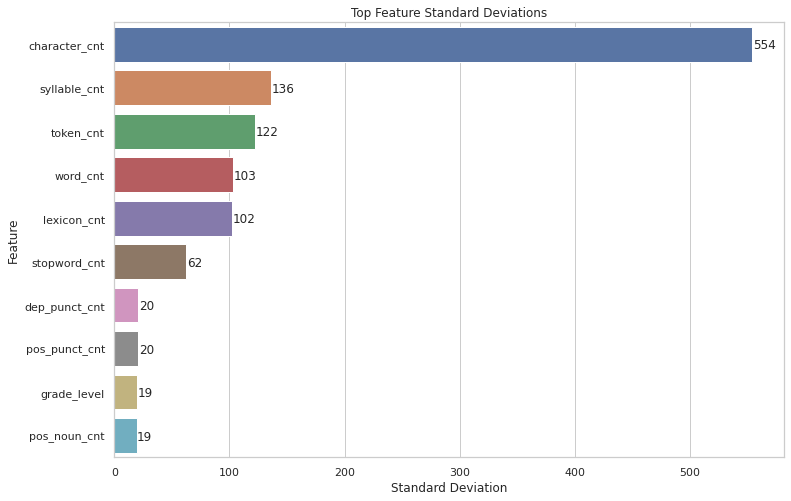

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=sorted_std[:10].values, y=sorted_std[:10].index, ax=ax)
ax.set_title("Top Feature Standard Deviations")
ax.set_ylabel("Feature")
ax.set_xlabel("Standard Deviation")
show_values_on_bars(ax)

In [21]:
sorted_std.iloc[-10:].index

Index(['dep_preconj_pct', 'ent_product_pct', 'ent_percent_pct',
       'ent_event_pct', 'ent_language_pct', 'dep_meta_pct', 'ent_law_pct',
       'dep_csubjpass_pct', 'pos_conj_cnt', 'pos_conj_pct'],
      dtype='object')

Text(0.5, 0, 'Standard Deviation')

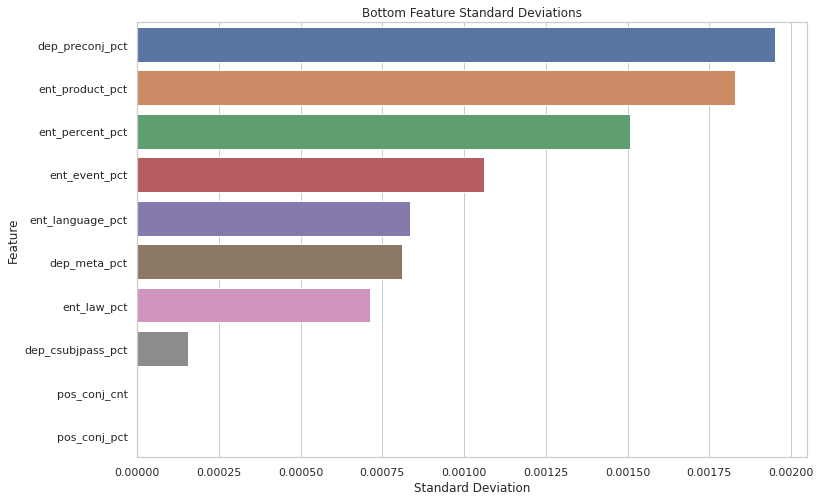

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=sorted_std.iloc[-10:].values, y=sorted_std.iloc[-10:].index, ax=ax)
ax.set_title("Bottom Feature Standard Deviations")
ax.set_ylabel("Feature")
ax.set_xlabel("Standard Deviation")
# show_values_on_bars(ax)

### Pearson Correlation

In [23]:
corr_results = f_regression(X_train, y_train)
sorted_corr_f_stats = pd.Series(corr_results[0], index=X_train.columns).sort_values(ascending=False)
sorted_corr_f_stats

/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


svm_pred              1139.22274
ent_cnt                681.44720
dep_pobj_cnt           638.44895
pos_propn_cnt          636.63278
dep_prep_cnt           620.91753
dep_compound_cnt       619.93835
token_cnt              615.17869
character_cnt          614.36062
pos_noun_cnt           605.97405
syllable_cnt           595.39097
lexicon_cnt            587.72652
word_cnt               583.85787
pos_adp_cnt            578.42316
dep_root_cnt           570.37885
ft_prob                563.09089
pos_det_cnt            532.68864
stopword_cnt           530.43725
dep_amod_cnt           524.65783
dep_det_cnt            520.31389
pos_adj_cnt            481.39363
dep_conj_cnt           477.50260
pos_aux_cnt            458.31592
dep_nsubj_cnt          458.18632
pos_verb_cnt           454.56375
dep_dobj_cnt           447.77973
dep_cc_cnt             419.90118
dep_aux_cnt            405.40137
pos_sconj_cnt          402.92241
ent_org_cnt            397.81117
pos_pron_cnt           397.00025
pos_part_c

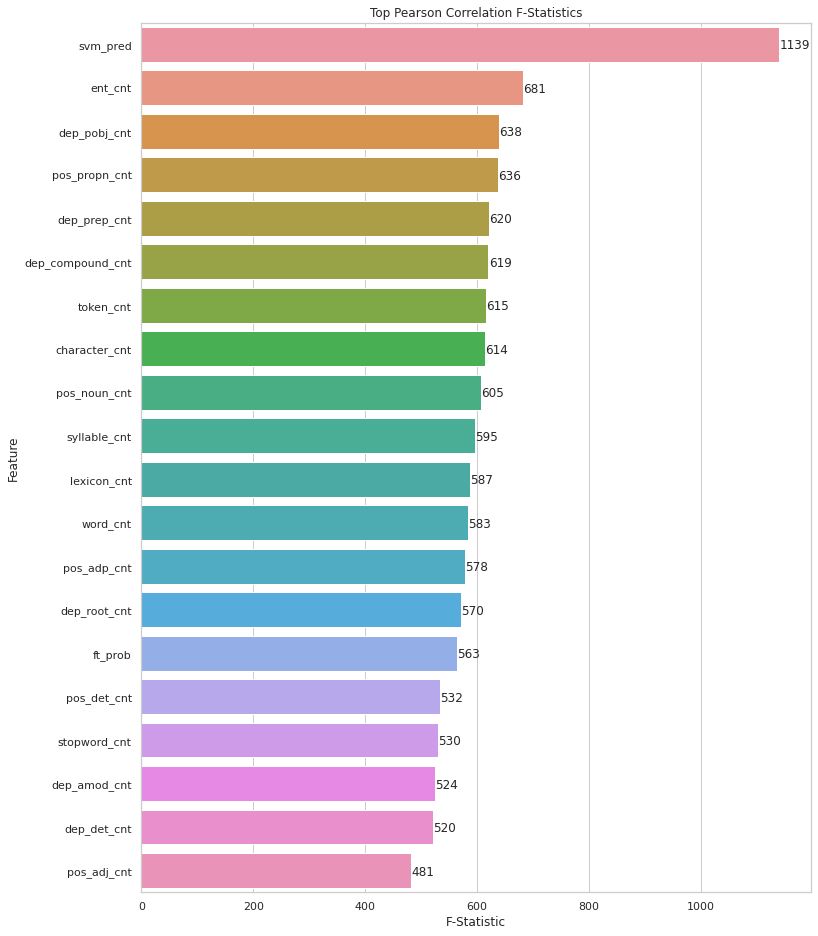

In [24]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=sorted_corr_f_stats.iloc[:20].values, y=sorted_corr_f_stats.iloc[:20].index, ax=ax)
ax.set_title("Top Pearson Correlation F-Statistics")
ax.set_ylabel("Feature")
ax.set_xlabel("F-Statistic")
show_values_on_bars(ax)

## Spearman Rank Correlation

In [25]:
rank_corr_results = stats.spearmanr(X_train, y_train.T)[0]

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [26]:
sorted_corr_f_stats = pd.Series(rank_corr_results[:-1,-1], index=X_train.columns).sort_values(ascending=False)
sorted_corr_f_stats

svm_pred               0.45916
ft_prob                0.41177
token_cnt              0.36323
lexicon_cnt            0.35701
character_cnt          0.35678
word_cnt               0.35600
stopword_cnt           0.35426
pos_punct_cnt          0.35371
syllable_cnt           0.35301
dep_punct_cnt          0.35291
pos_verb_cnt           0.34269
pos_noun_cnt           0.34023
pos_det_cnt            0.33739
dep_prep_cnt           0.33657
dep_nsubj_cnt          0.33607
pos_adp_cnt            0.33539
dep_pobj_cnt           0.33514
dep_root_cnt           0.33296
pos_pron_cnt           0.32820
dep_det_cnt            0.32276
dep_dobj_cnt           0.32038
dep_aux_cnt            0.31850
pos_aux_cnt            0.31439
pos_adv_cnt            0.31435
dep_advmod_cnt         0.31042
pos_sconj_cnt          0.29903
pos_part_cnt           0.29786
dep_advcl_cnt          0.29427
dep_cc_cnt             0.29190
nb_prob                0.29046
pos_adj_cnt            0.28768
ent_cnt                0.27967
dep_mark

Text(0.5, 0, 'F-Statistic')

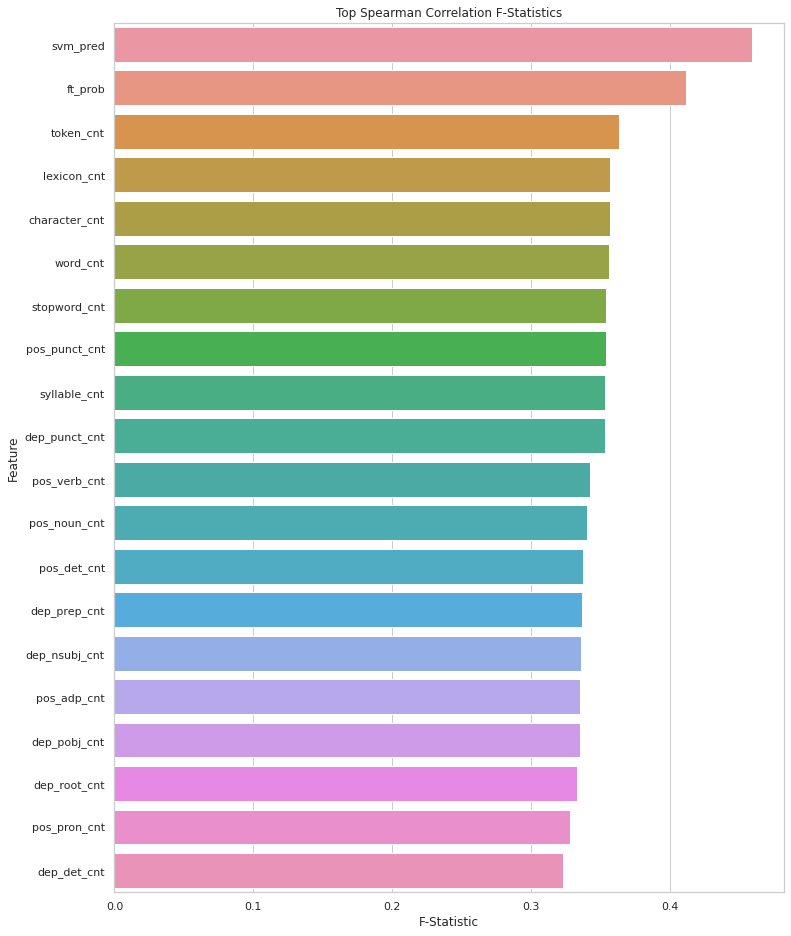

In [27]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=sorted_corr_f_stats.iloc[:20].values, y=sorted_corr_f_stats.iloc[:20].index, ax=ax)
ax.set_title("Top Spearman Correlation F-Statistics")
ax.set_ylabel("Feature")
ax.set_xlabel("F-Statistic")
# show_values_on_bars(ax)

### Mutual Info

In [28]:
mutual_info_results = mutual_info_regression(X_train, y_train)
sorted_mutual_info = pd.Series(mutual_info_results, index=X_train.columns).sort_values(ascending=False)
sorted_mutual_info

svm_pred              0.13357
ft_prob               0.10047
dep_punct_cnt         0.08864
stopword_cnt          0.07741
character_cnt         0.07625
pos_verb_cnt          0.07617
syllable_cnt          0.07563
pos_punct_cnt         0.07381
pos_noun_cnt          0.07134
token_cnt             0.07111
pos_det_cnt           0.06865
dep_root_cnt          0.06827
lexicon_cnt           0.06778
dep_prep_cnt          0.06713
pos_pron_cnt          0.06495
dep_nsubj_cnt         0.06198
word_cnt              0.06065
pos_adj_cnt           0.06023
pos_aux_cnt           0.05870
pos_adp_cnt           0.05734
dep_dobj_cnt          0.05708
dep_pobj_cnt          0.05680
dep_aux_cnt           0.05549
pos_adv_cnt           0.05545
dep_advcl_cnt         0.05493
pos_sconj_cnt         0.05419
lda_t1                0.05355
dep_det_cnt           0.05219
dep_mark_cnt          0.05124
dep_advmod_cnt        0.05112
nb_prob               0.05104
lda_t2                0.05022
dep_neg_pct           0.05011
dep_intj_p

Text(0.5, 0, 'Mutual Info')

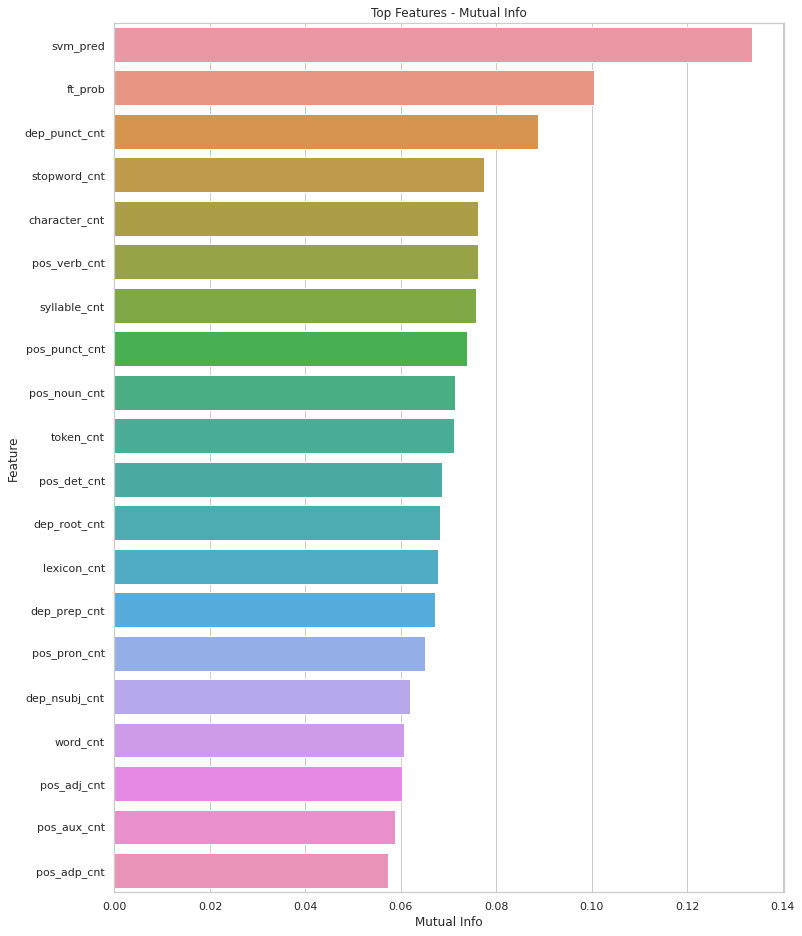

In [29]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=sorted_mutual_info.iloc[:20].values, y=sorted_mutual_info.iloc[:20].index, ax=ax)
ax.set_title("Top Features - Mutual Info")
ax.set_ylabel("Feature")
ax.set_xlabel("Mutual Info")
# show_values_on_bars(ax)

## Tree Based

### Feature Importances

In [30]:
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [31]:
feature_importances = pd.Series(forest.feature_importances_, index=X_train.columns)
feature_importances

review_stars          0.00166
nb_prob               0.00121
svm_pred              0.13455
ft_prob               0.03081
lda_t1                0.00496
lda_t2                0.01199
lda_t3                0.02587
lda_t4                0.01633
lda_t5                0.03595
grade_level           0.01350
polarity              0.00714
subjectivity          0.00828
word_cnt              0.00147
character_cnt         0.00353
num_cnt               0.00236
uppercase_cnt         0.00747
#@_cnt                0.00200
sentence_cnt          0.00228
lexicon_cnt           0.00153
syllable_cnt          0.00383
avg_word_len          0.01009
token_cnt             0.00286
stopword_cnt          0.00430
stopword_pct          0.00387
ent_cnt               0.00456
ent_pct               0.01220
pos_adj_pct           0.00829
pos_adj_cnt           0.00920
pos_adp_pct           0.00683
pos_adp_cnt           0.00496
pos_adv_pct           0.00858
pos_adv_cnt           0.00157
pos_aux_pct           0.00659
pos_aux_cn

In [32]:
sorted_fi = feature_importances.sort_values(ascending=False)
sorted_fi

svm_pred              0.13455
lda_t5                0.03595
ft_prob               0.03081
lda_t3                0.02587
dep_dobj_pct          0.02207
pos_sconj_pct         0.01761
lda_t4                0.01633
ent_person_pct        0.01437
grade_level           0.01350
ent_pct               0.01220
lda_t2                0.01199
dep_compound_pct      0.01160
dep_amod_pct          0.01098
dep_neg_pct           0.01046
pos_pron_pct          0.01038
dep_advcl_pct         0.01013
avg_word_len          0.01009
pos_sconj_cnt         0.00944
dep_intj_pct          0.00925
pos_adj_cnt           0.00920
dep_aux_pct           0.00909
pos_propn_cnt         0.00883
pos_adv_pct           0.00858
dep_compound_cnt      0.00845
dep_csubjpass_pct     0.00844
pos_adj_pct           0.00829
pos_noun_pct          0.00829
subjectivity          0.00828
pos_verb_cnt          0.00825
dep_det_pct           0.00813
dep_ccomp_pct         0.00808
uppercase_cnt         0.00747
pos_propn_pct         0.00737
dep_advmod

Text(0.5, 0, 'Importance Score')

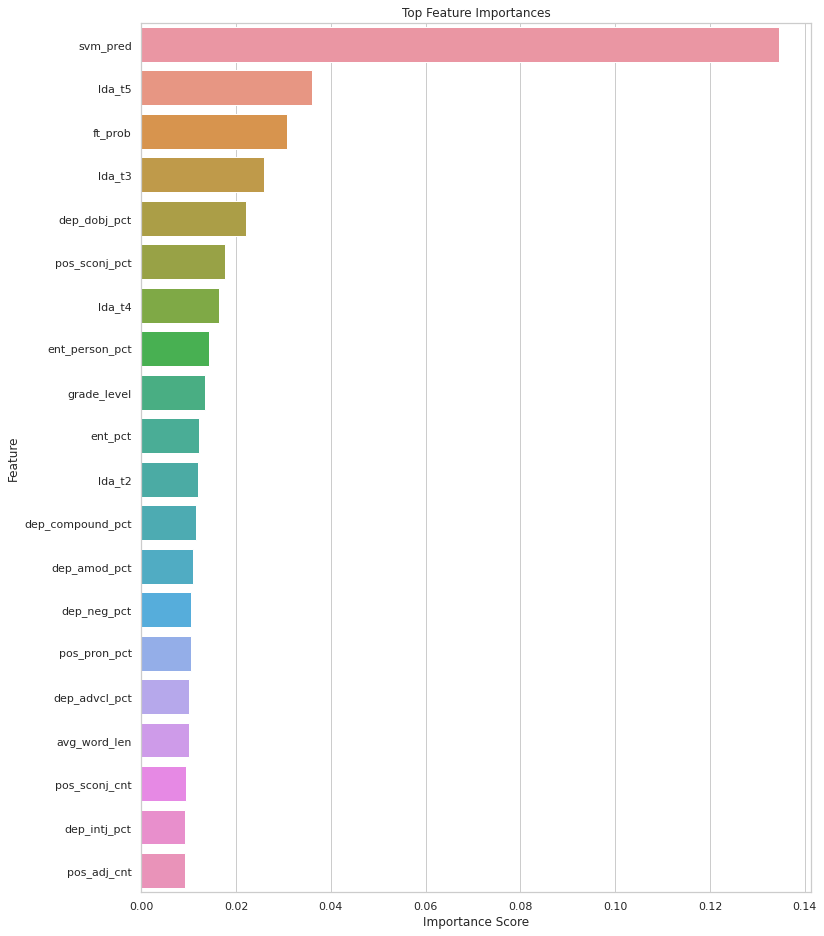

In [33]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=sorted_fi.iloc[:20].values, y=sorted_fi.iloc[:20].index, ax=ax)
ax.set_title("Top Feature Importances")
ax.set_ylabel("Feature")
ax.set_xlabel("Importance Score")

### Permutation Importances

In [34]:
pi_process = permutation_importance(forest, X_train, y_train, n_jobs=-1)

In [35]:
permutation_importances = pd.Series(pi_process.importances_mean, index=X_train.columns)
permutation_importances

review_stars          0.00417
nb_prob               0.00416
svm_pred              0.68329
ft_prob               0.24979
lda_t1                0.01087
lda_t2                0.01049
lda_t3                0.08796
lda_t4                0.01658
lda_t5                0.05178
grade_level           0.01495
polarity              0.01538
subjectivity          0.01061
word_cnt              0.00174
character_cnt         0.00299
num_cnt               0.00217
uppercase_cnt         0.01931
#@_cnt                0.00128
sentence_cnt          0.00223
lexicon_cnt           0.00159
syllable_cnt          0.00309
avg_word_len          0.01443
token_cnt             0.00473
stopword_cnt          0.00348
stopword_pct          0.00391
ent_cnt               0.00690
ent_pct               0.01762
pos_adj_pct           0.00828
pos_adj_cnt           0.00820
pos_adp_pct           0.01022
pos_adp_cnt           0.00322
pos_adv_pct           0.01246
pos_adv_cnt           0.00336
pos_aux_pct           0.01580
pos_aux_cn

In [36]:
sorted_pi = permutation_importances.sort_values(ascending=False)
sorted_pi

svm_pred              0.68329
ft_prob               0.24979
lda_t3                0.08796
dep_compound_cnt      0.08660
lda_t5                0.05178
dep_dobj_pct          0.05041
ent_person_pct        0.03915
dep_neg_pct           0.03323
dep_compound_pct      0.03321
dep_acomp_pct         0.02810
uppercase_cnt         0.01931
pos_propn_cnt         0.01893
ent_pct               0.01762
ent_norp_cnt          0.01730
lda_t4                0.01658
pos_aux_pct           0.01580
polarity              0.01538
grade_level           0.01495
avg_word_len          0.01443
pos_sconj_pct         0.01408
dep_amod_pct          0.01358
dep_advcl_pct         0.01316
pos_adv_pct           0.01246
dep_attr_pct          0.01134
dep_det_pct           0.01118
lda_t1                0.01087
ent_person_cnt        0.01084
subjectivity          0.01061
lda_t2                0.01049
pos_adp_pct           0.01022
ent_time_pct          0.00997
ent_gpe_pct           0.00989
dep_ccomp_pct         0.00914
dep_predet

Text(0.5, 0, 'Importance Score')

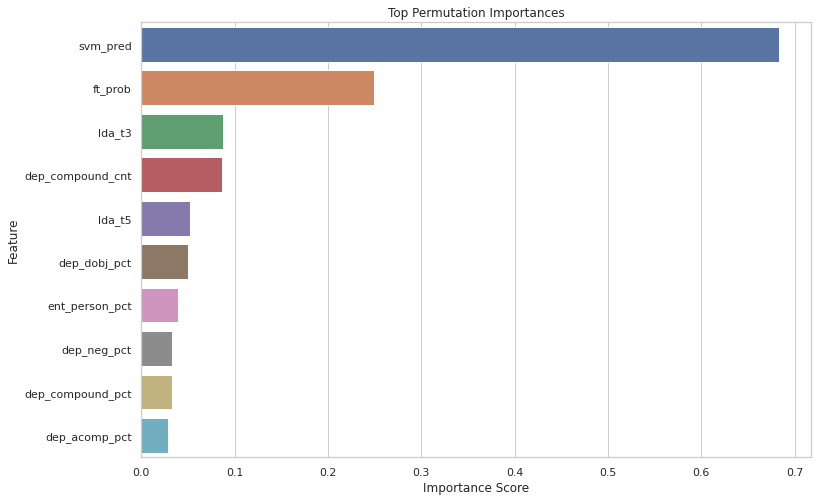

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=sorted_pi.iloc[:10].values, y=sorted_pi.iloc[:10].index, ax=ax)
ax.set_title("Top Permutation Importances")
ax.set_ylabel("Feature")
ax.set_xlabel("Importance Score")